In [1]:
import numpy as np

def cross_correlation_function(x, y, d):
    """
    Compute the normalized cross-correlation coefficient (CCF) of two 1D arrays x and y at delay d.
    Positive d means y is shifted right (delayed).
    Returns the correlation coefficient at delay d.
    """

    x = np.asarray(x)
    y = np.asarray(y)
    n = min(len(x), len(y))

    if d > 0:
        if d >= n:
            return 0.0
        x_seg = x[:n-d]
        y_seg = y[d:n]
    elif d < 0:
        if -d >= n:
            return 0.0
        x_seg = x[-d:n]
        y_seg = y[:n+d]
    else:
        x_seg = x[:n]
        y_seg = y[:n]

    if len(x_seg) == 0 or len(y_seg) == 0:
        return 0.0

    x_mean = np.mean(x_seg)
    y_mean = np.mean(y_seg)
    numerator = np.sum((x_seg - x_mean) * (y_seg - y_mean))
    denominator = np.sqrt(np.sum((x_seg - x_mean)**2)) * np.sqrt(np.sum((y_seg - y_mean)**2))
    if denominator == 0:
        return 0.0
    return numerator / denominator

In [2]:
#1.1 load data
import numpy as np
from pipeline.pca_diagnostics import *

data = np.load("/home/ktpha/chile-tellurics/pre/full_spectra/stacked_spectra_perstep.npz")
flux = data['flux']
wave = data['wave']

# 1.2 split into individual detectors & normalize. 
from pipeline.crires_functions import split_divide_by_median

normalized_flux = []
gaps_list = []  # Store gaps for each spectrum

for ii in range(len(flux)):
    single_flux = flux[ii, :]
    single_wave = wave[ii, :]
    
    single_norm_flux, gaps = split_divide_by_median(single_wave, single_flux, 5)
    
    normalized_flux.append(single_norm_flux)
    gaps_list.append(gaps)

normalized_flux_array, gaps_arr = np.array(normalized_flux), np.array(gaps_list)

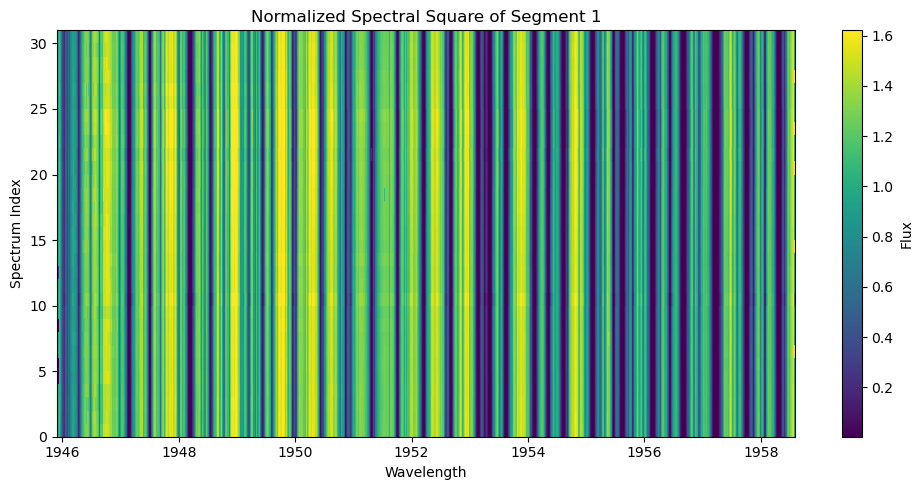

In [11]:
# for this example, we will only run the pipeline on one detector
wave_1 = wave[0, 0:gaps[0]]
flux_1 = normalized_flux_array[:, 0:gaps[0]]

nanmask = ~np.isnan(wave_1) & ~np.isnan(flux_1[0])

from pipeline.pca_diagnostics import plot_spectral_square
plot_spectral_square(flux_1[:, nanmask], wave_1[nanmask], title="Normalized Spectral Square of Segment 1")




In [12]:
# __ RUN PCA ON DATA __
import numpy as np

from pipeline.pca_subtraction import run_pca_on_detector_segments

tdm_concat, wdm_concat, wave_concat = run_pca_on_detector_segments(flux_1[:, nanmask], wave_1[nanmask], component_count=3, pre=True)

Processing segment 0: start=0, end=2047, length=2047
15th tdm, wdm values  [ 0.11962199 -0.06413514  0.92578327  0.13426567  0.08345684 -0.12133408
 -0.21363095  0.49391026 -0.27622738 -0.16622069  0.05087233 -0.1277714
  0.08026277 -0.07739511 -0.21831466  0.63484563 -0.15410449  0.23794687
  0.18755482 -0.11710477 -0.04715756  0.16847262  0.06051344 -0.02146768
 -0.06819687 -0.09051231  0.30527704 -0.11285819 -0.02592535  0.23254111
 -0.56218069] [ 3.66626893 -0.55971073  0.64961001 ... -2.71818444  0.
  0.        ] tdm, wdm shapes  (2047, 31) (31, 2047)


In [16]:
print(np.any(wdm_concat == 0))

True


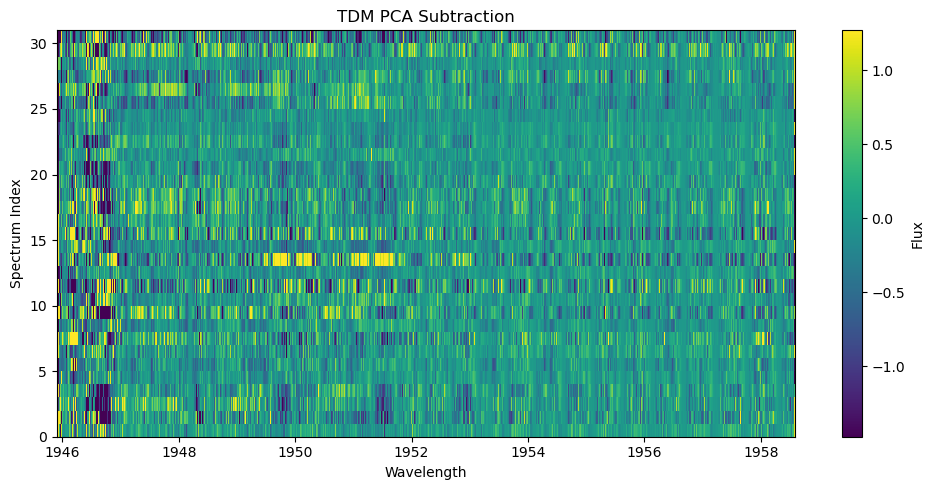

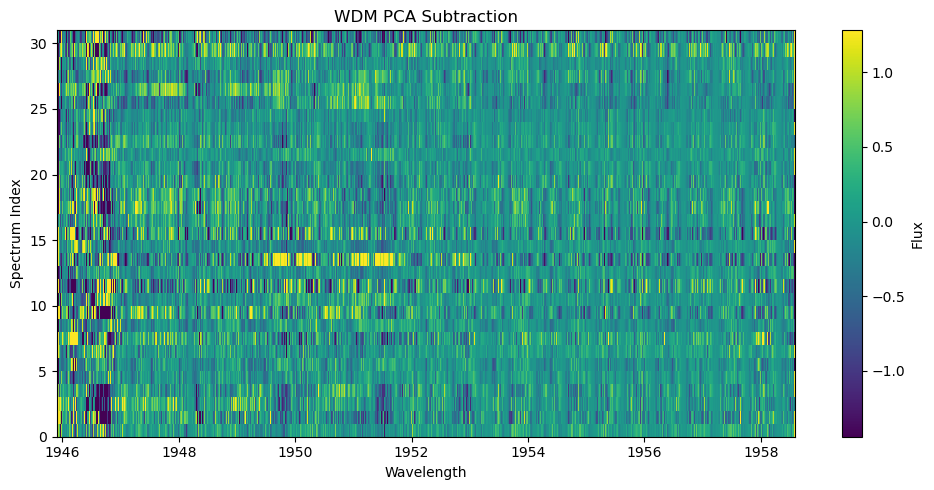

[[-1.07796454  0.69699646 -0.38143861 ...  1.19261881  0.
   0.        ]
 [ 3.92910433 -0.61518723 -0.73717148 ...  4.93945703  0.
   0.        ]
 [-0.71281098  0.98689467 -0.09071779 ...  4.23178361  0.
   0.        ]
 ...
 [-1.12918001 -0.20672062 -1.04510339 ...  2.58562634  0.
   0.        ]
 [ 3.50107175 -0.32697124 -1.58783268 ...  7.66701288  0.
   0.        ]
 [ 2.5157259  -1.75210837 -1.33586517 ...  8.12247799  0.
   0.        ]] [[-0.88004353  1.18530211 -1.06558468 ...  4.48025958  0.
   0.        ]
 [ 3.96440567  0.76599459 -0.82239603 ...  5.29883297  0.
   0.        ]
 [-1.09133592  2.13770984  0.82553057 ... -0.23346004  0.
   0.        ]
 ...
 [-0.99197483  0.6430103  -1.72276736 ...  5.73195     0.
   0.        ]
 [ 3.45583142  1.57471495 -1.39024159 ...  6.0412854   0.
   0.        ]
 [ 2.30697893 -0.32646176 -0.79783523 ...  5.26148133  0.
   0.        ]] (2047,)


In [ ]:
from pipeline.pca_diagnostics import *
plot_spectral_square(tdm_concat, wave_1[nanmask], title="TDM PCA Subtraction")
plot_spectral_square(wdm_concat, wave_1[nanmask], title="WDM PCA Subtraction")
#print(flux.shape, wave.shape)
#print(tdm_concat, wdm_concat, wave_concat.shape)

In [51]:
# __ SIMULATED SPECTRA __
import multirex as mrex

star=mrex.Star(temperature=3317,radius=0.3243,mass=0.312)
planet=mrex.Planet(radius=1.289,mass=2.770)
atmosphere=mrex.Atmosphere(
    temperature=696.3, # in K
    base_pressure=1e5, # in Pa
    top_pressure=1, # in Pa
    fill_gas="He", # the gas that fills the atmosphere
    
    composition=dict(
        CO=-4, # This is the log10(mix-ratio)
        H2O=-6,
    )
)
planet.set_atmosphere(atmosphere)
system=mrex.System(star=star,planet=planet,sma=0.01714)

system.make_tm()
wns = mrex.Physics.wavenumber_grid(wl_min=(1.9),wl_max=(2.5),resolution=10000)
wns, spectrum = system.generate_spectrum(wns)


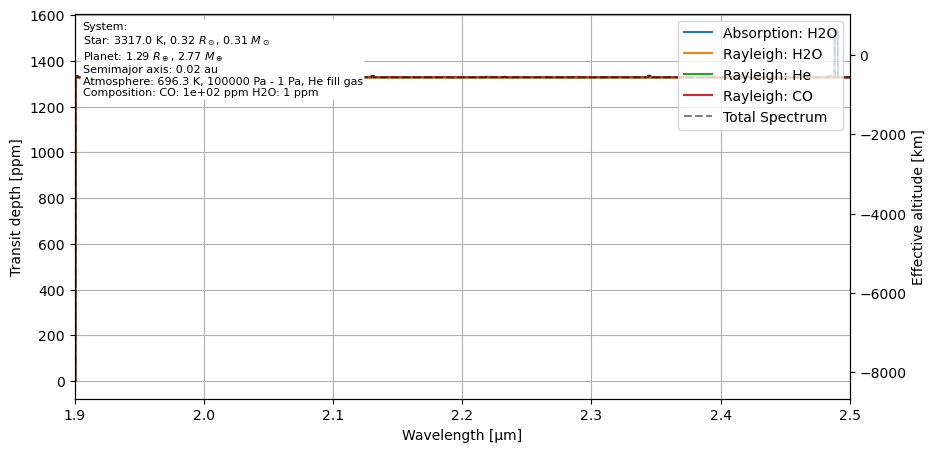

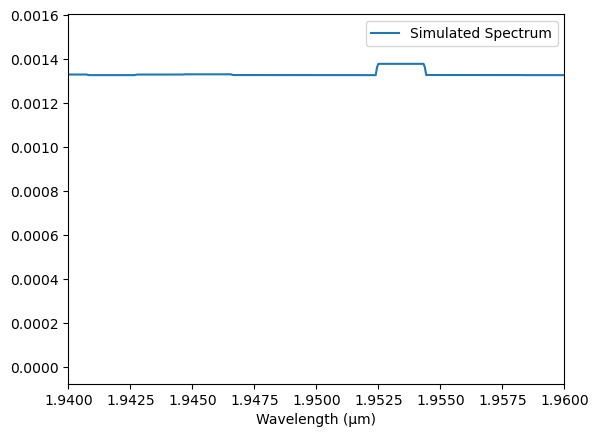

In [53]:
fig, ax = system.plot_contributions(wns)
# Convert wavenumber (cm^-1) to wavelength (microns)
wavelength_um = 1e4 / wns  # 1 micron = 1e4 Angstroms = 1e4 / (cm^-1)

# Sort so wavelength increases left to right
sort_idx = np.argsort(wavelength_um)
plt.plot(wavelength_um[sort_idx], spectrum[sort_idx], label="Simulated Spectrum")
plt.xlabel("Wavelength (μm)")
plt.legend()
plt.xlim(1.94, 1.96)
plt.show()

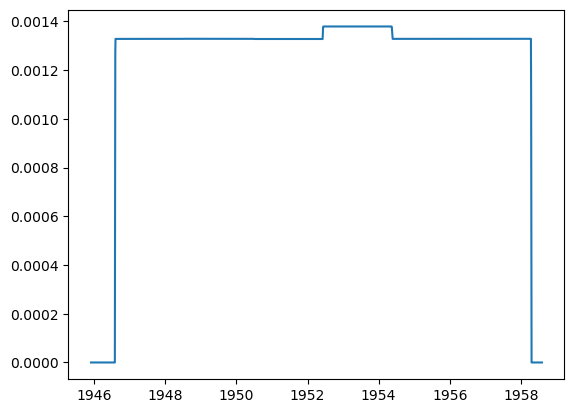

In [32]:
# Assume:
# - tdm_concat has shape (n_spectra, n_pixels)
# - spectrum is your simulated spectrum, on the same wavelength grid as wave_concat

# First, interpolate the simulation onto the observed wavelength grid if needed:
from scipy.interpolate import interp1d

sim_interp = interp1d(wavelength_um[sort_idx], spectrum[sort_idx], bounds_error=False, fill_value=0)
sim_on_obs_grid = sim_interp(wave_1[nanmask] * 0.001)  # wave_concat in nm, convert to um if needed

plt.plot(wave_1[nanmask], sim_on_obs_grid)


In [34]:
from astropy.constants import c
import astropy.units as u

def doppler_shift(wave_arr, velocity):
    """velocity in m/s"""
    return wave_arr * (1 + (velocity * u.m / u.s )/ c)

In [35]:
velocities = np.arange(-100_000, 100_001, 1000)  # in m/s

# Dictionary to hold shifted wave grids
shifted_wave_grids = {
    v: doppler_shift(wave_1[nanmask], v) for v in velocities
}

In [36]:
from astropy.constants import c
import astropy.units as u
from scipy.interpolate import interp1d
import numpy as np

def doppler_shift(wave_arr, velocity):
    """velocity in m/s"""
    return wave_arr * (1 + (velocity * u.m / u.s) / c)

def compute_ccf_over_velocity_range(data_wave, data_flux, model_flux, velocity_range):
    """
    Compute CCF between observed data and Doppler-shifted model over a velocity grid.

    Parameters:
        data_wave (1D array): Wavelength grid of observed data
        data_flux (1D array): Observed flux
        model_flux (1D array): Model flux defined on same wave grid
        velocity_range (1D array): Velocities (m/s) to Doppler shift model to

    Returns:
        velocities (1D array), ccfs (1D array)
    """
    ccfs = []
    interp_model = interp1d(data_wave, model_flux, kind='linear', bounds_error=False, fill_value=np.nan)

    for v in velocity_range:
        shifted_wave = doppler_shift(data_wave, v)
        shifted_model_flux = interp_model(shifted_wave)

        # Mask NaNs introduced by shifting out of bounds
        valid = ~np.isnan(shifted_model_flux) & ~np.isnan(data_flux)
        if np.sum(valid) < 10:
            ccfs.append(0.0)
            continue

        cc = cross_correlation_function(data_flux[valid], shifted_model_flux[valid], d=0)
        ccfs.append(cc)

    return velocity_range, np.array(ccfs)


In [40]:
print(wave_1[nanmask].shape, flux_1[0][nanmask].shape)

(2047,) (2047,)


In [45]:
# Velocity range from -100 km/s to 100 km/s in 1 km/s steps
velocities = np.arange(-100_000, 100_001, 1000)  # in m/s

# Run the CCF
vel_grid_2d = []
ccf_vals_2d = []

for ii in range(flux_1.shape[0]):
    vel_grid, ccf_vals = compute_ccf_over_velocity_range(wave_1[nanmask], flux_1[ii][nanmask], sim_on_obs_grid, velocities)
    vel_grid_2d.append(vel_grid)
    ccf_vals_2d.append(ccf_vals)
    

# # Plot
# import matplotlib.pyplot as plt
# plt.plot(vel_grid / 1000, ccf_vals)  # km/s on x-axis
# plt.xlabel("Radial Velocity (km/s)")
# plt.ylabel("Cross-Correlation Coefficient")
# plt.title("CCF vs Velocity")
# plt.grid(True)
# plt.show()

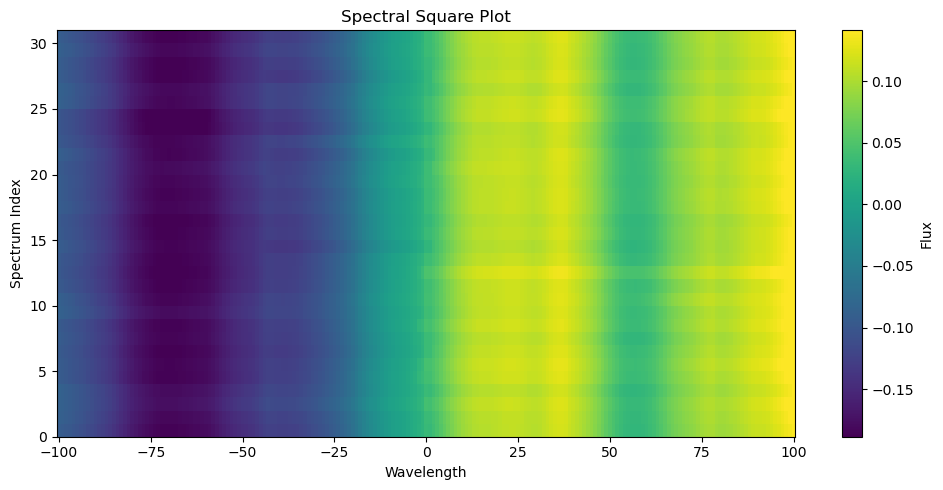

In [48]:
plot_spectral_square(np.array(ccf_vals_2d), np.array(vel_grid_2d)[0] / 1000)

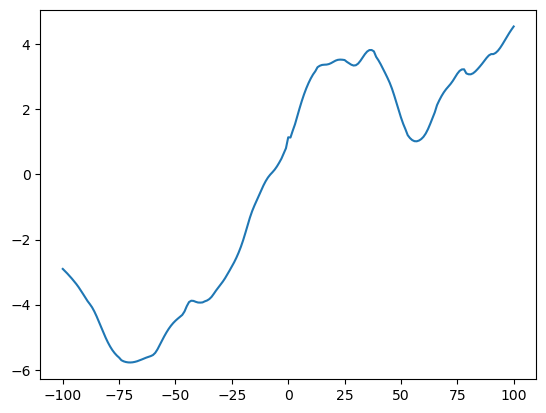

In [55]:
plt.plot(vel_grid_2d[0]/1000, np.sum(np.array(ccf_vals_2d), axis=0))